# Импорт

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from LookGenerator.datasets.utils import load_image
from LookGenerator.datasets.person_segmentation_dataset import PersonSegmentationDataset, PersonSegmentationDatasetMultichannel
from LookGenerator.networks.segmentation import UNet
from LookGenerator.networks.trainer import Trainer
from LookGenerator.networks.losses import FocalLossMulti
from LookGenerator.networks.utils import load_model
import LookGenerator.datasets.transforms as custom_transforms
from LookGenerator.networks_training.utils import check_path_and_creat

# Загрузка данных

In [2]:
transform_input = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.RandomAffine(scale=(0.8, 1), degrees=(-90,90), fill = 0.9),
    # transforms.ColorJitter(brightness=(0.5, 1), contrast=(0.4,1),  hue=(0, 0.3)),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.25, 0.25, 0.25]
    )
])

transform_output = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.RandomAffine(scale=(0.8, 1), degrees=(-90,90), fill = 0),
    custom_transforms.MinMaxScale(),
    custom_transforms.ThresholdTransform(threshold=0.5)
])

In [3]:
batch_size_train = 64
batch_size_val = 32
pin_memory = True
num_workers = 12

In [4]:
train_dataset = PersonSegmentationDatasetMultichannel(r'C:\Users\DenisovDmitrii\Desktop\12channels\trainData',
    #r"C:\Users\DenisovDmitrii\Desktop\trainData",
                                                      transform_input=transform_input,
                                                      transform_output=transform_output)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, pin_memory=pin_memory, num_workers=num_workers)
(len(train_dataset), len(train_dataloader))

(11647, 182)

In [5]:
val_dataset = PersonSegmentationDatasetMultichannel(r'C:\Users\DenisovDmitrii\Desktop\12channels\valData',
    #r"C:\Users\DenisovDmitrii\Desktop\trainData",
                                                      transform_input=transform_input,
                                                      transform_output=transform_output
                                                    )#r"C:\Users\DenisovDmitrii\Desktop\valData")
val_dataloader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False, pin_memory=pin_memory, num_workers=num_workers)
(len(val_dataset), len(val_dataloader))

(2032, 64)

Test load train_dataloader. and val.

torch.Size([64, 3, 256, 192])
torch.Size([64, 12, 256, 192])
False


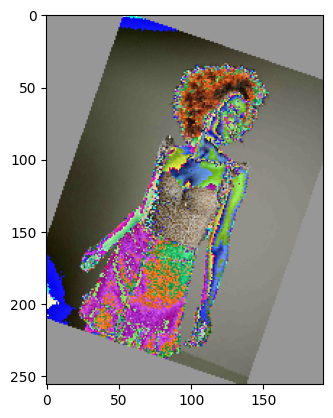

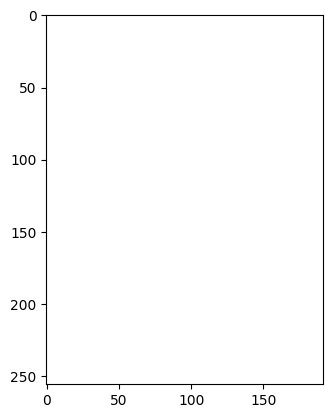

In [6]:
for X, y in train_dataloader:
    print(X.shape)
    print(y.shape)
    print(X.requires_grad)
    X = transforms.ToPILImage() (X[0])
    X = np.array(X)
    plt.imshow(X)
    plt.show()
    y = transforms.ToPILImage()(y[0,11])
    y = np.array(y)
    plt.imshow(y, cmap='binary')
    plt.show()

    break

# Обучение модели

torch.Size([32, 3, 256, 192])
torch.Size([32, 12, 256, 192])
False


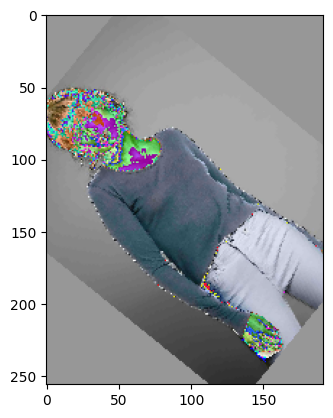

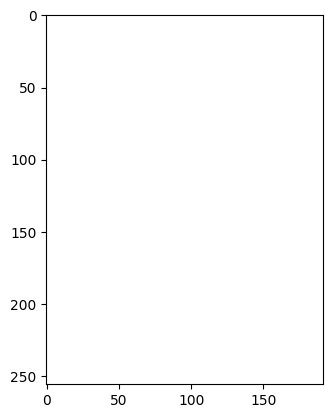

In [7]:
for X, y in val_dataloader:
    print(X.shape)
    print(y.shape)
    print(X.requires_grad)
    X = transforms.ToPILImage() (X[0])
    X = np.array(X)
    plt.imshow(X)
    plt.show()
    y = transforms.ToPILImage()(y[0,11])
    y = np.array(y)
    plt.imshow(y, cmap='binary')
    plt.show()

    break

Метки классов на изображении:

1. Левое лицо                       248,251,14
2. Правое лицо                      251,235,25
3. Туловище                         20,80,194
4. Внешняя верхняя левая рука       190,189,96
5. Внешняя верхняя правая рука      215,187,88
6. Внешняя нижняя левая рука        252,206,48
7. Внешняя нижняя правая рука       250,220,36
8. Внутренняя верхняя левая рука    145,191,116
9. Внутренняя верхняя правая рука   170,190,105
10. Внетренняя нижняя левая рука     228,191,74
11. Внутренняя нижняя правая рука    240,198,60
12. Левая кисть                      8,110,221
13. Правая кисть                     4,98,224
14. Левая нога                       22,173,184
15. Правая нога                      6,166,198

In [8]:
model = UNet(in_channels=3, out_channels = 12, features=(32, 64, 128, 256, 512, 1024),
             final_activation=nn.Softmax(dim=1))
#model = load_model(model, r'C:\Users\DenisovDmitrii\OneDrive - ITMO UNIVERSITY\peopleDetector\segmentationMulty\weights\testMulty_out_11\epoch_29.pt')
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = FocalLossMulti(device=device)
print(device)

cuda


In [9]:
save_directory = r'C:\Users\DenisovDmitrii\OneDrive - ITMO UNIVERSITY\peopleDetector\segmentationMulty\weights\testMulty_out_12_6features_32to1024'
check_path_and_creat(save_directory)

True

In [10]:
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = True

In [11]:
trainer = Trainer(
    model_=model, optimizer=optimizer, criterion=criterion,
    device=device, save_directory=save_directory, save_step=1, verbose=True
)

In [12]:
epoch_num=50

In [13]:
trainer.train(train_dataloader=train_dataloader, val_dataloader=val_dataloader, epoch_num=epoch_num)

start time 03-06-2023 21:11


100%|██████████| 182/182 [03:17<00:00,  1.09s/it]


Epoch 0 of 49, train loss: 0.00110
Epoch end time 03-06-2023 21:14


100%|██████████| 64/64 [00:37<00:00,  1.72it/s]


Epoch 0 of 49, val loss: 0.00082
Epoch end time 03-06-2023 21:15


100%|██████████| 182/182 [03:11<00:00,  1.05s/it]


Epoch 1 of 49, train loss: 0.00026
Epoch end time 03-06-2023 21:18


100%|██████████| 64/64 [00:34<00:00,  1.87it/s]


Epoch 1 of 49, val loss: 0.00029
Epoch end time 03-06-2023 21:19


100%|██████████| 182/182 [03:10<00:00,  1.05s/it]


Epoch 2 of 49, train loss: 0.00023
Epoch end time 03-06-2023 21:22


100%|██████████| 64/64 [00:33<00:00,  1.91it/s]


Epoch 2 of 49, val loss: 0.00068
Epoch end time 03-06-2023 21:23


100%|██████████| 182/182 [03:10<00:00,  1.04s/it]


Epoch 3 of 49, train loss: 0.00016
Epoch end time 03-06-2023 21:26


100%|██████████| 64/64 [00:33<00:00,  1.89it/s]


Epoch 3 of 49, val loss: 0.00053
Epoch end time 03-06-2023 21:26


100%|██████████| 182/182 [03:08<00:00,  1.04s/it]


Epoch 4 of 49, train loss: 0.00013
Epoch end time 03-06-2023 21:29


100%|██████████| 64/64 [00:33<00:00,  1.94it/s]


Epoch 4 of 49, val loss: 0.00053
Epoch end time 03-06-2023 21:30


100%|██████████| 182/182 [03:08<00:00,  1.03s/it]


Epoch 5 of 49, train loss: 0.00011
Epoch end time 03-06-2023 21:33


100%|██████████| 64/64 [00:33<00:00,  1.93it/s]


Epoch 5 of 49, val loss: 0.00035
Epoch end time 03-06-2023 21:34


100%|██████████| 182/182 [03:08<00:00,  1.04s/it]


Epoch 6 of 49, train loss: 0.00011
Epoch end time 03-06-2023 21:37


100%|██████████| 64/64 [00:33<00:00,  1.91it/s]


Epoch 6 of 49, val loss: 0.00109
Epoch end time 03-06-2023 21:37


100%|██████████| 182/182 [03:09<00:00,  1.04s/it]


Epoch 7 of 49, train loss: 0.00011
Epoch end time 03-06-2023 21:41


100%|██████████| 64/64 [00:33<00:00,  1.92it/s]


Epoch 7 of 49, val loss: 0.00153
Epoch end time 03-06-2023 21:41


100%|██████████| 182/182 [03:12<00:00,  1.06s/it]


Epoch 8 of 49, train loss: 0.00012
Epoch end time 03-06-2023 21:44


100%|██████████| 64/64 [00:35<00:00,  1.78it/s]


Epoch 8 of 49, val loss: 0.00044
Epoch end time 03-06-2023 21:45


100%|██████████| 182/182 [03:50<00:00,  1.27s/it]


Epoch 9 of 49, train loss: 0.00009
Epoch end time 03-06-2023 21:49


100%|██████████| 64/64 [00:36<00:00,  1.75it/s]


Epoch 9 of 49, val loss: 0.00027
Epoch end time 03-06-2023 21:49


100%|██████████| 182/182 [03:18<00:00,  1.09s/it]


Epoch 10 of 49, train loss: 0.00008
Epoch end time 03-06-2023 21:53


100%|██████████| 64/64 [00:37<00:00,  1.71it/s]


Epoch 10 of 49, val loss: 0.00082
Epoch end time 03-06-2023 21:53


100%|██████████| 182/182 [05:01<00:00,  1.66s/it]


Epoch 11 of 49, train loss: 0.00009
Epoch end time 03-06-2023 21:58


100%|██████████| 64/64 [00:36<00:00,  1.75it/s]


Epoch 11 of 49, val loss: 0.00140
Epoch end time 03-06-2023 21:59


100%|██████████| 182/182 [04:31<00:00,  1.49s/it]


Epoch 12 of 49, train loss: 0.00008
Epoch end time 03-06-2023 22:04


100%|██████████| 64/64 [00:36<00:00,  1.75it/s]


Epoch 12 of 49, val loss: 0.00012
Epoch end time 03-06-2023 22:04


100%|██████████| 182/182 [05:16<00:00,  1.74s/it]


Epoch 13 of 49, train loss: 0.00008
Epoch end time 03-06-2023 22:09


100%|██████████| 64/64 [00:35<00:00,  1.79it/s]


Epoch 13 of 49, val loss: 0.00160
Epoch end time 03-06-2023 22:10


100%|██████████| 182/182 [04:51<00:00,  1.60s/it]


Epoch 14 of 49, train loss: 0.00009
Epoch end time 03-06-2023 22:15


100%|██████████| 64/64 [00:33<00:00,  1.88it/s]


Epoch 14 of 49, val loss: 0.00135
Epoch end time 03-06-2023 22:16


100%|██████████| 182/182 [03:30<00:00,  1.16s/it]


Epoch 15 of 49, train loss: 0.00011
Epoch end time 03-06-2023 22:19


100%|██████████| 64/64 [00:35<00:00,  1.81it/s]


Epoch 15 of 49, val loss: 0.00056
Epoch end time 03-06-2023 22:20


100%|██████████| 182/182 [03:40<00:00,  1.21s/it]


Epoch 16 of 49, train loss: 0.00009
Epoch end time 03-06-2023 22:23


100%|██████████| 64/64 [00:34<00:00,  1.83it/s]


Epoch 16 of 49, val loss: 0.00029
Epoch end time 03-06-2023 22:24


100%|██████████| 182/182 [03:20<00:00,  1.10s/it]


Epoch 17 of 49, train loss: 0.00009
Epoch end time 03-06-2023 22:27


100%|██████████| 64/64 [00:33<00:00,  1.90it/s]


Epoch 17 of 49, val loss: 0.00062
Epoch end time 03-06-2023 22:28


100%|██████████| 182/182 [03:10<00:00,  1.04s/it]


Epoch 18 of 49, train loss: 0.00007
Epoch end time 03-06-2023 22:31


100%|██████████| 64/64 [00:33<00:00,  1.90it/s]


Epoch 18 of 49, val loss: 0.00169
Epoch end time 03-06-2023 22:32


100%|██████████| 182/182 [03:09<00:00,  1.04s/it]


Epoch 19 of 49, train loss: 0.00007
Epoch end time 03-06-2023 22:35


100%|██████████| 64/64 [00:33<00:00,  1.91it/s]


Epoch 19 of 49, val loss: 0.00115
Epoch end time 03-06-2023 22:35


100%|██████████| 182/182 [03:14<00:00,  1.07s/it]


Epoch 20 of 49, train loss: 0.00008
Epoch end time 03-06-2023 22:38


100%|██████████| 64/64 [00:33<00:00,  1.90it/s]


Epoch 20 of 49, val loss: 0.00257
Epoch end time 03-06-2023 22:39


100%|██████████| 182/182 [03:19<00:00,  1.10s/it]


Epoch 21 of 49, train loss: 0.00008
Epoch end time 03-06-2023 22:42


100%|██████████| 64/64 [00:35<00:00,  1.80it/s]


Epoch 21 of 49, val loss: 0.00011
Epoch end time 03-06-2023 22:43


100%|██████████| 182/182 [03:34<00:00,  1.18s/it]


Epoch 22 of 49, train loss: 0.00010
Epoch end time 03-06-2023 22:47


100%|██████████| 64/64 [00:34<00:00,  1.86it/s]


Epoch 22 of 49, val loss: 0.00015
Epoch end time 03-06-2023 22:47


100%|██████████| 182/182 [03:41<00:00,  1.22s/it]


Epoch 23 of 49, train loss: 0.00007
Epoch end time 03-06-2023 22:51


100%|██████████| 64/64 [00:35<00:00,  1.81it/s]


Epoch 23 of 49, val loss: 0.00154
Epoch end time 03-06-2023 22:51


100%|██████████| 182/182 [03:46<00:00,  1.24s/it]


Epoch 24 of 49, train loss: 0.00007
Epoch end time 03-06-2023 22:55


100%|██████████| 64/64 [00:35<00:00,  1.82it/s]


Epoch 24 of 49, val loss: 0.00018
Epoch end time 03-06-2023 22:56


100%|██████████| 182/182 [03:48<00:00,  1.26s/it]


Epoch 25 of 49, train loss: 0.00006
Epoch end time 03-06-2023 23:00


100%|██████████| 64/64 [00:34<00:00,  1.83it/s]


Epoch 25 of 49, val loss: 0.00178
Epoch end time 03-06-2023 23:00


100%|██████████| 182/182 [03:27<00:00,  1.14s/it]


Epoch 26 of 49, train loss: 0.00008
Epoch end time 03-06-2023 23:04


100%|██████████| 64/64 [00:34<00:00,  1.86it/s]


Epoch 26 of 49, val loss: 0.00010
Epoch end time 03-06-2023 23:04


100%|██████████| 182/182 [03:27<00:00,  1.14s/it]


Epoch 27 of 49, train loss: 0.00006
Epoch end time 03-06-2023 23:08


100%|██████████| 64/64 [00:35<00:00,  1.78it/s]


Epoch 27 of 49, val loss: 0.00193
Epoch end time 03-06-2023 23:08


100%|██████████| 182/182 [03:17<00:00,  1.08s/it]


Epoch 28 of 49, train loss: 0.00007
Epoch end time 03-06-2023 23:12


100%|██████████| 64/64 [00:34<00:00,  1.86it/s]


Epoch 28 of 49, val loss: 0.00019
Epoch end time 03-06-2023 23:12


100%|██████████| 182/182 [03:30<00:00,  1.15s/it]


Epoch 29 of 49, train loss: 0.00007
Epoch end time 03-06-2023 23:16


100%|██████████| 64/64 [00:35<00:00,  1.78it/s]


Epoch 29 of 49, val loss: 0.00253
Epoch end time 03-06-2023 23:16


100%|██████████| 182/182 [03:40<00:00,  1.21s/it]


Epoch 30 of 49, train loss: 0.00006
Epoch end time 03-06-2023 23:20


100%|██████████| 64/64 [00:37<00:00,  1.70it/s]


Epoch 30 of 49, val loss: 0.00129
Epoch end time 03-06-2023 23:21


100%|██████████| 182/182 [03:13<00:00,  1.06s/it]


Epoch 31 of 49, train loss: 0.00006
Epoch end time 03-06-2023 23:24


100%|██████████| 64/64 [00:35<00:00,  1.79it/s]


Epoch 31 of 49, val loss: 0.00231
Epoch end time 03-06-2023 23:24


100%|██████████| 182/182 [03:25<00:00,  1.13s/it]


Epoch 32 of 49, train loss: 0.00006
Epoch end time 03-06-2023 23:28


100%|██████████| 64/64 [00:35<00:00,  1.81it/s]


Epoch 32 of 49, val loss: 0.00207
Epoch end time 03-06-2023 23:28


100%|██████████| 182/182 [03:31<00:00,  1.16s/it]


Epoch 33 of 49, train loss: 0.00006
Epoch end time 03-06-2023 23:32


100%|██████████| 64/64 [00:36<00:00,  1.75it/s]


Epoch 33 of 49, val loss: 0.00324
Epoch end time 03-06-2023 23:33


100%|██████████| 182/182 [03:45<00:00,  1.24s/it]


Epoch 34 of 49, train loss: 0.00005
Epoch end time 03-06-2023 23:36


100%|██████████| 64/64 [00:37<00:00,  1.69it/s]


Epoch 34 of 49, val loss: 0.00008
Epoch end time 03-06-2023 23:37


100%|██████████| 182/182 [03:28<00:00,  1.14s/it]


Epoch 35 of 49, train loss: 0.00006
Epoch end time 03-06-2023 23:40


100%|██████████| 64/64 [00:35<00:00,  1.82it/s]


Epoch 35 of 49, val loss: 0.00020
Epoch end time 03-06-2023 23:41


100%|██████████| 182/182 [03:24<00:00,  1.12s/it]


Epoch 36 of 49, train loss: 0.00006
Epoch end time 03-06-2023 23:44


100%|██████████| 64/64 [00:35<00:00,  1.81it/s]


Epoch 36 of 49, val loss: 0.00006
Epoch end time 03-06-2023 23:45


100%|██████████| 182/182 [03:22<00:00,  1.11s/it]


Epoch 37 of 49, train loss: 0.00006
Epoch end time 03-06-2023 23:48


100%|██████████| 64/64 [00:33<00:00,  1.89it/s]


Epoch 37 of 49, val loss: 0.00076
Epoch end time 03-06-2023 23:49


100%|██████████| 182/182 [03:11<00:00,  1.05s/it]


Epoch 38 of 49, train loss: 0.00006
Epoch end time 03-06-2023 23:52


100%|██████████| 64/64 [00:33<00:00,  1.90it/s]


Epoch 38 of 49, val loss: 0.00268
Epoch end time 03-06-2023 23:53


100%|██████████| 182/182 [03:10<00:00,  1.05s/it]


Epoch 39 of 49, train loss: 0.00006
Epoch end time 03-06-2023 23:56


100%|██████████| 64/64 [00:33<00:00,  1.91it/s]


Epoch 39 of 49, val loss: 0.00058
Epoch end time 03-06-2023 23:56


100%|██████████| 182/182 [03:10<00:00,  1.04s/it]


Epoch 40 of 49, train loss: 0.00006
Epoch end time 04-06-2023 00:00


100%|██████████| 64/64 [00:33<00:00,  1.90it/s]


Epoch 40 of 49, val loss: 0.00026
Epoch end time 04-06-2023 00:00


100%|██████████| 182/182 [03:13<00:00,  1.06s/it]


Epoch 41 of 49, train loss: 0.00007
Epoch end time 04-06-2023 00:03


100%|██████████| 64/64 [00:34<00:00,  1.86it/s]


Epoch 41 of 49, val loss: 0.00015
Epoch end time 04-06-2023 00:04


100%|██████████| 182/182 [03:16<00:00,  1.08s/it]


Epoch 42 of 49, train loss: 0.00005
Epoch end time 04-06-2023 00:07


100%|██████████| 64/64 [00:35<00:00,  1.81it/s]


Epoch 42 of 49, val loss: 0.00015
Epoch end time 04-06-2023 00:08


100%|██████████| 182/182 [03:13<00:00,  1.07s/it]


Epoch 43 of 49, train loss: 0.00005
Epoch end time 04-06-2023 00:11


100%|██████████| 64/64 [00:34<00:00,  1.83it/s]


Epoch 43 of 49, val loss: 0.00245
Epoch end time 04-06-2023 00:12


100%|██████████| 182/182 [03:38<00:00,  1.20s/it]


Epoch 44 of 49, train loss: 0.00005
Epoch end time 04-06-2023 00:15


100%|██████████| 64/64 [00:36<00:00,  1.76it/s]


Epoch 44 of 49, val loss: 0.00251
Epoch end time 04-06-2023 00:16


100%|██████████| 182/182 [03:32<00:00,  1.17s/it]


Epoch 45 of 49, train loss: 0.00006
Epoch end time 04-06-2023 00:20


100%|██████████| 64/64 [00:34<00:00,  1.85it/s]


Epoch 45 of 49, val loss: 0.00043
Epoch end time 04-06-2023 00:20


100%|██████████| 182/182 [03:22<00:00,  1.11s/it]


Epoch 46 of 49, train loss: 0.00005
Epoch end time 04-06-2023 00:23


100%|██████████| 64/64 [00:35<00:00,  1.82it/s]


Epoch 46 of 49, val loss: 0.00011
Epoch end time 04-06-2023 00:24


100%|██████████| 182/182 [03:15<00:00,  1.08s/it]


Epoch 47 of 49, train loss: 0.00005
Epoch end time 04-06-2023 00:27


100%|██████████| 64/64 [00:36<00:00,  1.75it/s]


Epoch 47 of 49, val loss: 0.00280
Epoch end time 04-06-2023 00:28


100%|██████████| 182/182 [03:33<00:00,  1.17s/it]


Epoch 48 of 49, train loss: 0.00005
Epoch end time 04-06-2023 00:32


100%|██████████| 64/64 [00:35<00:00,  1.79it/s]


Epoch 48 of 49, val loss: 0.00006
Epoch end time 04-06-2023 00:32


100%|██████████| 182/182 [03:25<00:00,  1.13s/it]


Epoch 49 of 49, train loss: 0.00004
Epoch end time 04-06-2023 00:36


100%|██████████| 64/64 [00:35<00:00,  1.82it/s]


Epoch 49 of 49, val loss: 0.00203
Epoch end time 04-06-2023 00:36
end time 04-06-2023 00:36
delta 3:24:57.869415


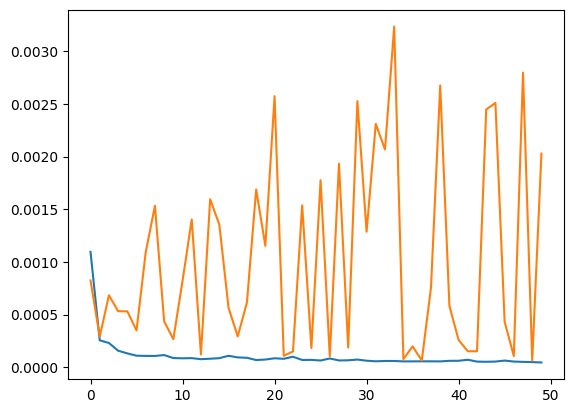

In [14]:
trainer.draw_history_plots()

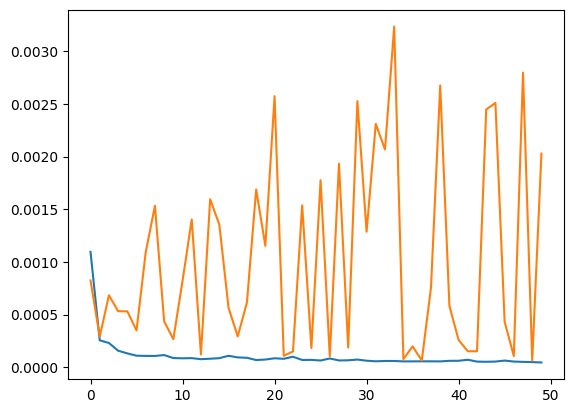

In [15]:
trainer.save_history_plots(save_directory)

In [16]:
trainer.create_readme(save_directory)

AttributeError: 'UNet' object has no attribute 'latent_dim_size'

In [17]:
from torchsummary import summary
summary(model.to('cuda'), (3, 256, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 192]           1,792
       BatchNorm2d-2         [-1, 64, 256, 192]             128
         LeakyReLU-3         [-1, 64, 256, 192]               0
         LeakyReLU-4         [-1, 64, 256, 192]               0
           Conv3x3-5         [-1, 64, 256, 192]               0
            Conv2d-6         [-1, 64, 256, 192]          36,928
       BatchNorm2d-7         [-1, 64, 256, 192]             128
           Conv3x3-8         [-1, 64, 256, 192]               0
         LeakyReLU-9         [-1, 64, 256, 192]               0
        LeakyReLU-10         [-1, 64, 256, 192]               0
          Conv5x5-11         [-1, 64, 256, 192]               0
        MaxPool2d-12          [-1, 64, 128, 96]               0
           Conv2d-13         [-1, 128, 128, 96]          73,856
      BatchNorm2d-14         [-1, 128, 

In [ ]:
model = load_model(model, r'C:\Users\Даша\PycharmProjects\SMBackEnd\LookGenerator\weights\unet_epoch_0_0.0161572862694324.pt')
model.eval()

In [ ]:
test_dir = r""
test_folder = ""
save_masks_dir = r""
list_files = os.listdir(test_dir)
images = [file.split('.') for file in list_files]

In [ ]:
for image in images:
    print(image)
    img = load_image(test_dir, test_folder, image, '.jpg')
    img_to_model = prepare_image_for_model(img, transform_input)
    modelled = model(img_to_model)
    mask = to_array_from_model_bin(modelled)

    plt.figure(figsize=(18, 6))
    plt.subplot(1,2,0)
    plt.imshow(img)
    plt.subplot(1,2,1)
    plt.imshow(mask)

    Image.fromarray(mask, 'L').save(save_masks_dir + image + '.png')
